# Satelite imagery in the Torres Strait (Digital Globe)

This document shows the high-resolution DigitalGlobe imagery of the Torres Strait for 2016 and 2017. Two outcomes come from this document. First, it shows how spatialy distributed are the images over the selected zone. Second, it create a visualization tool to capture the more frequent days of collection. For both years recolectation rates are low and not cover the total extension of the Torres Strait area. 


<h1><center>Torres Strait (May 2016 - Jun 2017)</center></h1>

In [2]:
import gbdxtools
import numpy as np
#import geopandas as gpd
from matplotlib import pyplot as plt
import shapely as sp
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import mapping, shape
from gbdx_auth import gbdx_auth
import geojson, json
from pprint import pprint
import pandas as pd
import urllib.request
%matplotlib inline

#Open a session using the Authentication files (~/.gbdx-config)
gbdx = gbdx_auth.get_session()
gbdx = gbdxtools.Interface()

In [3]:
from pprint import pprint
import json
#Create a area to search and retrieve information
torres_strait = "POLYGON((139.0 -9.0, 145.0 -9.0, 145 -12, 139 -12, 139 -9.0))"
world = "POLYGON((-180 -90, -180 90, 180 90, 180 -90, -180 -90))"
filters = ["cloudCover < 30"]
types = ['DigitalGlobeAcquisition']



#Divide results to get the total and avoid the API limit (1000 imgs)
results_query = []

results_query.extend(gbdx.catalog.search(searchAreaWkt= torres_strait,
                                         startDate="2016-05-01T00:00:00.000Z",
                                         endDate="2016-12-31T00:00:00.000Z",
                                         #filters=filters,
                                         types = types))
                     
                     
results_query.extend(gbdx.catalog.search(searchAreaWkt= torres_strait,
                                         startDate="2017-01-01T00:00:00.000Z",
                                         endDate="2017-06-30T00:00:00.000Z",
                                         #filters=filters,
                                         types = types))

            
    

In [4]:
#Results is a json object (which is already a list, so no need of json.loads). First we can try with the first
#element of the json list.
a = results_query[1]['properties']['footprintWkt']
a_sp = sp.wkt.loads(a)

#We have retrieve this number of images
print("We have "+ str(len(results_query)) + " images available in the selected area!")

#Now that we have this, we can explore the spatial distribution of the images
tiles = []
for tile in results_query:
    tiles.append(tile['properties']['footprintWkt'])


We have 1183 images available in the selected area!


In [5]:
#Interactive plot with available imagery
from geomet import wkt
import pandas as pd
from pandas.io.json import json_normalize
import folium

#Create an interactive Leaflet map with the location of the torres strait
torres_strait = folium.Map(location = [-10.144989750644969, 142.3181966067051,], 
                           tiles='OpenStreetMap', 
                           zoom_start=6
                          )

#Option 1: Only plot the available images with the same color
tiles_geojson = []
for img in results_query:
    tiles_geojson.append(wkt.loads(img['properties']['footprintWkt']))
    for tile in tiles_geojson:
        tile["properties"] = img["properties"]
        
        
style_function = lambda x: {'borderColor': 'rgba(255, 0, 0, 0)'}

for tile in tiles_geojson:
    folium.GeoJson(tile, style_function=style_function).add_to(torres_strait)
        
#Option 2: Create a pd DataFrame to make a cloropeth by month
df_imgs = list(map(lambda x: x["properties"], results_query))
data_imgs = pd.read_json(json.dumps(df_imgs))

#If you want to explore the data dataframe you can print:
#print(data_imgs)




In [6]:
torres_strait.save("gbdx_torres_strait_coverage.html")

In [6]:
#Explore time of the images
data_imgs["timestamp"] = pd.to_datetime(data_imgs["timestamp"])
data_imgs["date"] = pd.DatetimeIndex(data_imgs["timestamp"]).normalize() #This is not needed, is only to learn how to remove time from timestamps
data_imgs["day"], data_imgs["month"] = data_imgs["timestamp"].dt.day, data_imgs["timestamp"].dt.month
data_imgs["hour"], data_imgs["minute"], data_imgs["second"] = data_imgs["timestamp"].dt.hour, data_imgs["timestamp"].dt.minute, data_imgs["timestamp"].dt.second 
#print(data_imgs)

data_imgs_agg = pd.DataFrame(data_imgs.groupby(["date"]).size().rename("counts"))
data_imgs_agg["date"] = data_imgs_agg.index
data_imgs_agg["day"], data_imgs_agg["month"], data_imgs_agg["year"] = data_imgs_agg["date"].dt.day, data_imgs_agg["date"].dt.month, data_imgs_agg["date"].dt.year 
data_imgs_agg["month_year"] = data_imgs_agg['month'].map(str)+"-"+data_imgs_agg["year"].map(str)


In [7]:
#Create pivot table to visualize time
data_imgs_piv = data_imgs_agg.pivot(index='day', columns="month_year", values='counts')
data_imgs_piv = data_imgs_piv.fillna(0)
#print(data_imgs_piv)

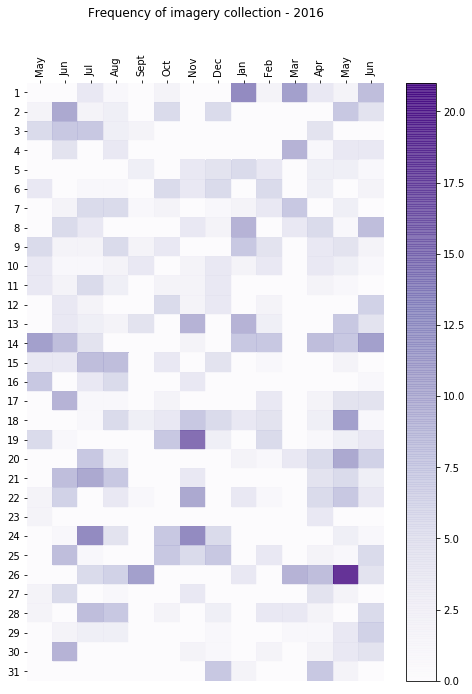

In [8]:
#Method taken from: http://nbviewer.jupyter.org/gist/joelotz/5427209 based on FlowingData Graph. 

# Plot it out
fig, ax = plt.subplots()
heatmap = ax.pcolor(data_imgs_piv, cmap=plt.cm.Purples, alpha=0.8)

##################################################
## FORMAT ##
##################################################

fig = plt.gcf()
fig.set_size_inches(8,11)

# turn off the frame
ax.set_frame_on(False)
fig.colorbar(heatmap)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(data_imgs_piv.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(data_imgs_piv.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# Set the labels
labels = ["May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec", 'Jan', "Feb", "Mar", "Apr", "May", "Jun"]

# note I could have used nba_sort.columns but made "labels" instead
ax.set_xticklabels(labels, minor=False) 
ax.set_yticklabels(data_imgs_piv.index, minor=False)

# rotate the 
plt.xticks(rotation=90)
ax.grid(False)

# Turn off all the ticks
ax = plt.gca()
ax.set_title('Frequency of imagery collection - 2016\n\n\n\n') 
#plt.savefig('/mnt/data/shared/timeavailable.png')
